In [1]:
import json

In [2]:
import numpy as np
import pandas as pd

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch import matrix_exp
from tqdm import tqdm
import matplotlib.pyplot as plt

# Dataset Preprocessing

In [4]:
def json_formatter(data_dict):
    keys = list(data_dict.keys())
    data_list = []
    for key in keys:
        braids = data_dict[key]
        for braid in braids:
            word = braid[0]
            coords = braid[1]
            data = (int(key), braid[0], braid[1])
            data_list.append(data)
    return data_list

In [5]:
def onehot(word, word_length, num_generators = 2):
    #Creates onehot encoding of braid word: Set of N generators are mapped to a binary vector. Generator g_i has a 1 in index i and 0 elsewhere
    #Note that generator g_i and its inverse are treated as 2 independent generators. If there are N generators with N inverses, the binary vector will be 2N dim.
    if word_length < 1:
        word_length = 1
    val = torch.zeros((word_length, num_generators*2))
    for (i,a) in enumerate(word):
        if a < 0:
            temp = torch.abs(a)
            j = int(temp + num_generators - 1)
        else:
            j = int(a - 1)
        val[i, j] = 1
    return val
            
def signed_onehot(word, word_length, num_generators = 2):
    #Signed version of onehot encoding. Same as normal onehot, g_i will have a 1 in index i and 0 elsewhere. 
    #Instead of treating inverses as indepedent, inv(g_i) will have a -1 at index i and 0 elsewhere. N generators and N inverses will have N dim vectors.
    if word_length < 1:
        word_length = 1
    val = torch.zeros((word_length, num_generators))
    for (i,a) in enumerate(word):
        j = int(torch.abs(a) - 1)
        if a < 0:
            val[i,j] =  -1
        else:
            val[i,j] = 1
    return val

In [6]:
class onehot_transform:
    #Transform class for data loading in pytorch. Applies the onehot transformation to the input data.
    def __init__(self, num_generators = 2, signed = False):
        self.num_generators = num_generators
        self.signed = signed
    def __call__(self, word, word_length):
        if self.signed:
            val = signed_onehot(word, word_length, self.num_generators)
        else:
            val = onehot(word, word_length, num_generators = self.num_generators)
        return val
        
        

In [7]:
class BraidDataset(Dataset):
    #Pytorch dataset class for loading in data from JSON file. Has options for variable word length but are not used as of yet. 
    def __init__(self, data_file, transform = None, max_length = False,
                 target_transform = None):
        with open(data_file, "r") as f:
            data_dict = json.load(f)
        self.data_list = json_formatter(data_dict)
        if max_length:
            self.max_length = max([d[0] for d in self.data_list])
        else:
            self.max_length = -1
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        #word_length = torch.Tensor([data[0]])
        word = torch.Tensor(data[1])
        coords = torch.Tensor(data[2])
        if self.max_length == -1:
            if data[0] < 1:
                word_length = 1
            else:
                word_length = data[0]
        else:
            word_length = self.max_length
        if self.transform:
            word = self.transform(word, word_length)
        if self.target_transform:
            coords = self.target_transform(coords)
        word_length = torch.Tensor([word_length])
        return word_length, word, coords
            
        

# Model Definitions

In [8]:
class BraidResNet(nn.Module):
    #Recurrent/Residual model that takes in a braid word and sequentially learns an invertible matrix representation of each element in the word. 
    #The matrices are right multiplied in sequence to get a final output matrix representation of the braid word. 
    def __init__(self, num_generators, hidden_rep_size, matrix_size, hidden_class_size, output_size, signed = False):
        super(BraidResNet, self).__init__()
        if signed:
            self.input_size = num_generators
        else:
            self.input_size = num_generators*2
        self.identity_ele = torch.zeros(self.input_size)
        self.hidden_rep_size = hidden_rep_size
        self.matrix_size = matrix_size
        self.hidden_class_size = hidden_class_size
        self.output_size = output_size
        self.signed = signed
        self.l1 = nn.Linear(self.input_size, hidden_rep_size)
        self.l2 = nn.Linear(hidden_rep_size, hidden_rep_size)
        self.l3 = nn.Linear(hidden_rep_size, matrix_size**2)
        self.nonlin = nn.ReLU()
        self.l1_class = nn.Linear(matrix_size**2, hidden_class_size)
        self.l2_class = nn.Linear(hidden_class_size, hidden_class_size)
        self.out = nn.Linear(hidden_class_size, output_size)
        
    def res_block(self, x):
        #Res/Recurrent block that computes matrix
        #Find all non-identity braid elements
        nonzero_elements = torch.nonzero(torch.all(x == self.identity_ele, dim = 1))
        mat = self.nonlin(self.l1(x))
        mat = self.nonlin(self.l2(mat))
        mat = self.l3(mat)
        mat = mat.reshape((-1,self.matrix_size, self.matrix_size))
        mat = matrix_exp(x)
        #identity_matrix = torch.eye(self.matrix_size, self.matrix_size)
        #mat[nonzero_elements, :, :] = 
        return mat
    
    def forward(self, x, word_length = -1):
        if word_length == -1:
            braid_length = x.size(1)
        else:
            word_length = braid_length
        braid = x[:,0,:]
        mat_rep = self.res_block(braid)
        for i in range(1,braid_length):
            braid = x[:,i,:]
            temp = self.res_block(braid)
            mat_rep = torch.matmul(mat_rep, temp)
        flattened_rep = torch.reshape(mat_rep, (-1, self.matrix_size**2))
        output = self.nonlin(self.l1_class(flattened_rep))
        output = self.nonlin(self.l2_class(output))
        output = self.out(output)
        return output


            



In [9]:
class BraidMLP(nn.Module):
    #Simple MLP that takes in flattened onehot encodings.
    def __init__(self, num_generators, max_length, hidden_size, output_size, signed = False):
        super(BraidMLP, self).__init__()
        if signed:
            self.input_size = num_generators*max_length
        else:
            self.input_size = num_generators*2*max_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.signed = signed
        self.l1 = nn.Linear(self.input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.nonlin = nn.ReLU()
    def forward(self,x):
        x = self.l1(x)
        x = self.nonlin(x)
        x = self.l2(x)
        x = self.nonlin(x)
        x = self.l3(x)
        x = self.nonlin(x)
        x = self.nonlin(self.l4(x))
        output = self.out(x)
        return output

# Training/Eval Scripts

In [10]:
def eval(model, test_loader, reshaped_size, batch_size = 64, device = 'cuda:0', model_type = "mlp"):
    model.eval()
    losses = []
    y0_accs = []
    y1_accs = []
    y2_accs = []
    loss_fn = nn.MSELoss()
    for test_step, batch in enumerate(test_loader):
        if batch_size == batch[1].size(0):
            if model_type == "mlp":
                x = batch[1].reshape(batch_size, reshaped_size).to(device)
            else:
                x = batch[1].to(device)
            y = batch[2].to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            loss = loss.cpu().item()
            y0_acc, y1_acc, y2_acc = comp_y_accs(pred, y)

            
            losses.append(loss)
            y0_accs.append(y0_acc)
            y1_accs.append(y1_acc)
            y2_accs.append(y2_acc)
    avg_loss = np.mean(losses)
    avg_y0_acc = np.mean(y0_accs)
    avg_y1_acc = np.mean(y1_accs)
    avg_y2_acc = np.mean(y2_accs)
    return losses, avg_loss, avg_y0_acc, avg_y1_acc, avg_y2_acc

def train(model, train_loader, test_loader, optimizer, num_epochs = 50, batch_size = 64, device = 'cuda:0', model_type = "mlp"):
    losses = []
    y0_accs = []
    y1_accs = []
    y2_accs = []
    y0_train_accs = []
    y1_train_accs = []
    y2_train_accs = []
    y0_test_accs = []
    y1_test_accs = []
    y2_test_accs = []
    reshaped_size = 2*6
    loss_fn = nn.MSELoss()
    epoch_train_losses = []
    epoch_test_losses = []
    for i in tqdm(range(num_epochs)):
        epoch_losses = []
        y0_temp = []
        y1_temp = []
        y2_temp = []
        model.train()
        for train_step, batch in enumerate(train_loader):
            if batch_size == batch[1].size(0):
                if model_type == "mlp":
                    x = batch[1].reshape(batch_size, reshaped_size).to(device)
                else:
                    x = batch[1].to(device)
                y = batch[2].to(device)
                braid_length = batch[0]
                optimizer.zero_grad()

                pred = model(x)
                rounded = torch.round(pred)
                
                loss = loss_fn(pred, y)
                #print(loss)
                loss.backward()
                optimizer.step()

                y0_acc, y1_acc, y2_acc = comp_y_accs(pred, y)
                temp = loss.cpu().item()
                losses.append(temp)
                epoch_losses.append(temp)
                
                y0_temp.append(y0_acc)
                y1_temp.append(y1_acc)
                y2_temp.append(y2_acc)
                y0_accs += y0_temp
                y1_accs += y1_temp
                y2_accs += y2_temp
                
        test_losses, avg_test_loss, test_y0_acc, test_y1_acc, test_y2_acc = eval(model, test_loader, reshaped_size, batch_size, device, model_type)
        
        epoch_avg = np.mean(epoch_losses)
        epoch_train_losses.append(epoch_avg)
        epoch_test_losses.append(avg_test_loss)
        
        y0_train_accs.append(np.mean(y0_temp))
        y1_train_accs.append(np.mean(y1_temp))
        y2_train_accs.append(np.mean(y2_temp))
        
        y0_test_accs.append(test_y0_acc)
        y1_test_accs.append(test_y1_acc)
        y2_test_accs.append(test_y2_acc)
        
    return losses, epoch_train_losses, epoch_test_losses, (y0_train_accs, y1_train_accs, y2_train_accs), (y0_test_accs, y1_test_accs, y2_test_accs)

def comp_y_accs(pred, y):
    rounded = torch.round(pred)
    y0_acc = (rounded[:,0] == y[:,0]).cpu().float().mean()
    y1_acc = (rounded[:,1] == y[:,1]).cpu().float().mean()
    y2_acc = (rounded[:,2] == y[:,2]).cpu().float().mean()
    return y0_acc, y1_acc, y2_acc

In [11]:
def run(model, device, train_loader, test_loader, num_epochs, batch_size, model_type = "mlp"):
    optimizer = optim.Adam(model.parameters(), lr = 1e-4)
    losses, epoch_train_losses, epoch_test_losses, y_train_accs, y_test_accs = train(model, train_loader, test_loader, optimizer, num_epochs = num_epochs, batch_size = batch_size, model_type=model_type)
    return losses, epoch_train_losses, epoch_test_losses, y_train_accs, y_test_accs

# Preliminary Tests

In [13]:
num_generators = 2
batch_size = 64
max_length = 6
hidden_size = 128
output_size = 3
signed = True
device = 'cuda:0'
num_y0_vals = 14 #{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
num_y1_vals = 8 #{0, 1, 2, 3, 4, 5, 7, 8}
num_y2_vals = 14 #{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

onehot_dataset = BraidDataset("hn-data-a2.json", max_length = True, transform = onehot_transform(num_generators, signed))
onehot_train, onehot_test = random_split(onehot_dataset, [0.8, 0.2])
train_loader = DataLoader(onehot_train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(onehot_test, batch_size = batch_size, shuffle = True)

mlp = BraidMLP(num_generators, max_length, hidden_size, output_size, signed)
mlp.to(device)
optimizer = optim.Adam(mlp.parameters(), lr = 1e-4)
mlp_losses, mlp_train_losses, mlp_test_losses, mlp_train_accs, mlp_test_accs = run(mlp, device, train_loader, test_loader, num_epochs = 100, batch_size = batch_size, model_type = "mlp")

100%|██████████| 100/100 [05:11<00:00,  3.12s/it]


In [14]:
num_generators = 2
batch_size = 64
max_length = 6
max_length = False
hidden_rep_size = 128
hidden_class_size = 128
matrix_size = 8
output_size = 3
signed = True
device = 'cuda:0'
num_y0_vals = 14 #{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
num_y1_vals = 8 #{0, 1, 2, 3, 4, 5, 7, 8}
num_y2_vals = 14 #{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

onehot_dataset = BraidDataset("hn-data-a2.json", max_length = True, transform = onehot_transform(num_generators, signed))
onehot_train, onehot_test = random_split(onehot_dataset, [0.8, 0.2])
train_loader = DataLoader(onehot_train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(onehot_test, batch_size = batch_size, shuffle = True)
resnet = BraidResNet(num_generators, hidden_rep_size, matrix_size, hidden_class_size, output_size, signed)
resnet.to(device)

BraidResNet(
  (l1): Linear(in_features=2, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=64, bias=True)
  (nonlin): ReLU()
  (l1_class): Linear(in_features=64, out_features=128, bias=True)
  (l2_class): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=3, bias=True)
)

In [12]:
num_generators = 2
batch_size = 64
max_length = 6
max_length = False
hidden_rep_size = 128
hidden_class_size = 128
matrix_size = 8
output_size = 3
signed = True
device = 'cuda:0'
num_y0_vals = 14 #{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
num_y1_vals = 8 #{0, 1, 2, 3, 4, 5, 7, 8}
num_y2_vals = 14 #{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

onehot_dataset = BraidDataset("hn-data-a2.json", max_length = True, transform = onehot_transform(num_generators, signed))
onehot_train, onehot_test = random_split(onehot_dataset, [0.8, 0.2])
train_loader = DataLoader(onehot_train, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(onehot_test, batch_size = batch_size, shuffle = True)

In [13]:
test = next(iter(train_loader))

In [16]:
print(test[1].size())

torch.Size([64, 6, 2])


In [26]:
ident = torch.zeros((1,6,2))
test = torch.cat((test[1],ident), dim = 0)

In [27]:
zero_token = torch.zeros(2)

In [29]:
temp = test[:,0,:]

In [31]:
print(temp)

tensor([[ 0.,  1.],
        [-1.,  0.],
        [ 1.,  0.],
        [-1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  0.],
        [-1.,  0.],
        [ 0.,  1.],
        [-1.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 0., -1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.],
        [ 0., -1.],
        [ 0.,  1.],
        [ 0., -1.],
        [ 0.,  1.],
        [ 0.,  1.],
        [-1.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.],
        [ 0., -1.],
        [ 0., -1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 0.,  1.],
        [ 0., -1.],
        [ 0., -1.],
        [-1.,  0.],
        [ 0.,  1.],
        [ 0., -1.],
        [-1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.],


In [35]:
torch.all(temp == zero_token, dim = 1).size()

torch.Size([65])

In [15]:
res_losses, res_train_losses, res_test_losses, res_train_accs, res_test_accs = run(resnet, device, train_loader, test_loader, num_epochs = 100, batch_size = batch_size, model_type = "resnet")

100%|██████████| 100/100 [10:44<00:00,  6.45s/it]


# Result Plots

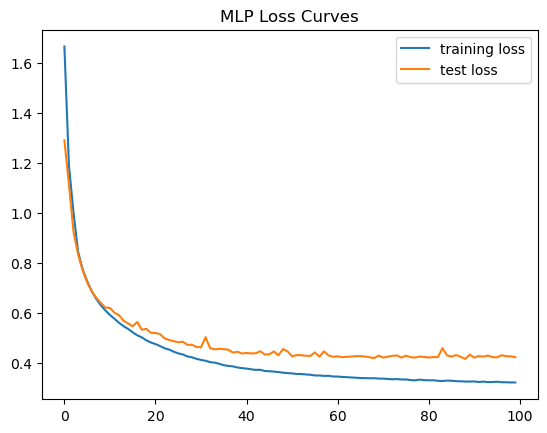

In [16]:
plt.plot(mlp_train_losses, label = "training loss")
plt.plot(mlp_test_losses, label = "test loss")
plt.legend()
plt.title("MLP Loss Curves")
plt.savefig("mlp_loss.png")

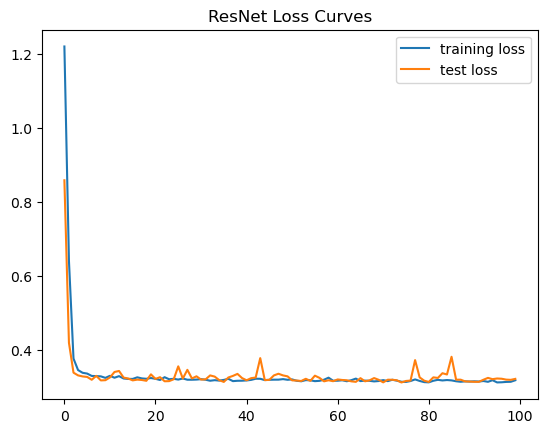

In [17]:
plt.plot(res_train_losses, label = "training loss")
plt.plot(res_test_losses, label = "test loss")
plt.legend()
plt.title("ResNet Loss Curves")
plt.savefig("res_loss.png")

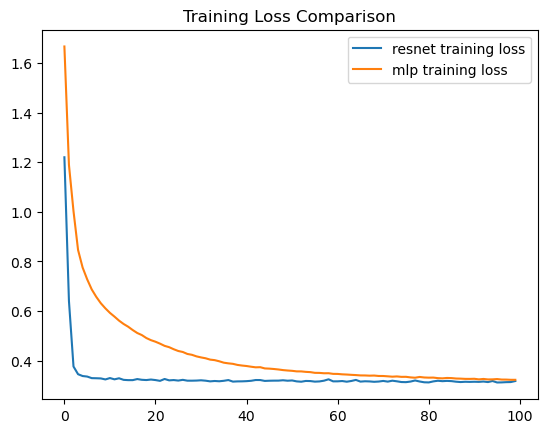

In [18]:
plt.plot(res_train_losses, label = "resnet training loss")
plt.plot(mlp_train_losses, label = "mlp training loss")
plt.legend()
plt.title("Training Loss Comparison")
plt.savefig("both_train_loss.png")

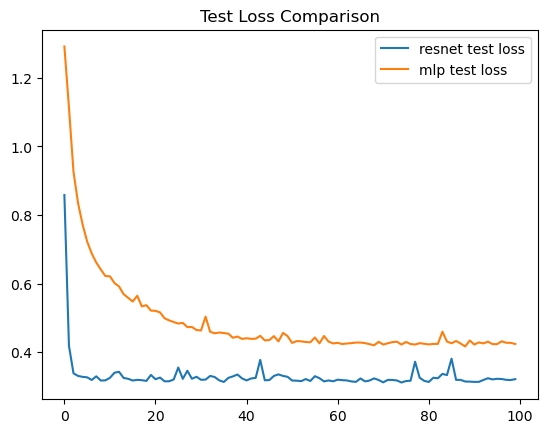

In [19]:
plt.plot(res_test_losses, label = "resnet test loss")
plt.plot(mlp_test_losses, label = "mlp test loss")
plt.legend()
plt.title("Test Loss Comparison")
plt.savefig("both_test_loss.png")

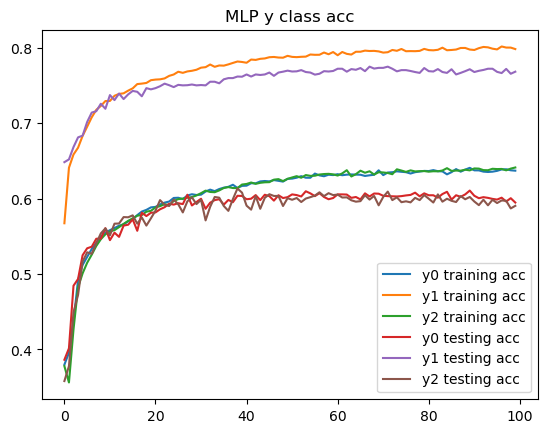

In [20]:
for i in range(3):
    plt.plot(mlp_train_accs[i], label = "y{} training acc".format(i))
for i in range(3):
    plt.plot(mlp_test_accs[i], label = "y{} testing acc".format(i))
plt.legend()
plt.title("MLP y class acc")
plt.savefig("mlp_accs.png")

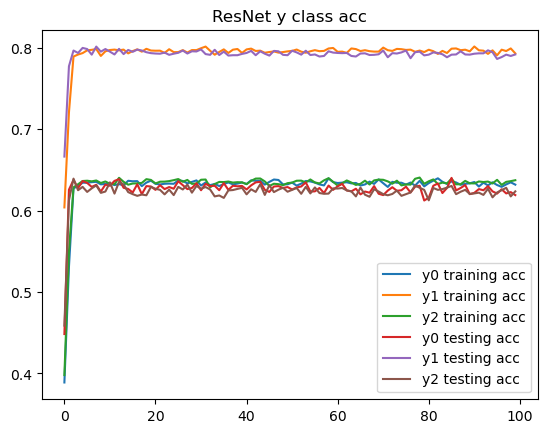

In [21]:
for i in range(3):
    plt.plot(res_train_accs[i], label = "y{} training acc".format(i))
for i in range(3):
    plt.plot(res_test_accs[i], label = "y{} testing acc".format(i))
plt.legend()
plt.title("ResNet y class acc")
plt.savefig("res_accs.png")

In [ ]:
# Small batch size 20-30 -> table of outputs
# confusion matrix for each yi coordinate over full test set
# True distributions for each yi coordinate and for model output